In [1]:
!pip install -q -U fireducks

In [2]:
%load_ext fireducks.pandas
import numpy as np
import pandas as pd

### 1. Common Sub-expression Elimination

In [3]:
def generate_random_dates(size):
    year = [str(i) for i in np.random.choice(range(2000, 2005), size)]
    month = [str(i).zfill(2) for i in np.random.choice(range(1, 13), size)]
    day = [str(i).zfill(2) for i in np.random.choice(range(1, 29), size)]
    return pd.Series(year) + "-" + pd.Series(month) + "-" + pd.Series(day)

s = generate_random_dates(10 ** 3)
s

0      2000-01-22
1      2004-12-25
2      2004-09-11
3      2002-03-16
4      2003-11-01
          ...    
995    2003-06-17
996    2004-06-25
997    2002-11-16
998    2000-02-06
999    2003-08-18
Length: 1000, dtype: object

In [4]:
def demo_cse(s, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)

    df = pd.DataFrame()
    df["year"] = pd.to_datetime(s).dt.year
    df["month"] = pd.to_datetime(s).dt.month
    df["day"] = pd.to_datetime(s).dt.day
    # sample operation: calculate year-month-wise frequency of days
    df.groupby(["year", "month"])["day"].count().plot()

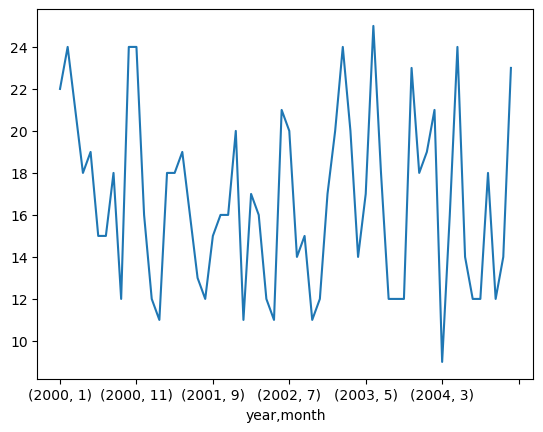

,name,type,n_calls,duration (msec)
0,to_datetime,kernel,1,2.939880
1,datetime_extract,kernel,3,2.273093
2,groupby_select_agg,kernel,1,0.764152
3,to_pandas.frame.metadata,kernel,1,0.498579
4,from_pandas.frame.metadata,kernel,1,0.205130
5,setitem,kernel,3,0.012917
6,getattr:plot,fallback,1,0.009056


In [5]:
%%fireducks.profile
demo_cse(s, is_eager_mode = False)

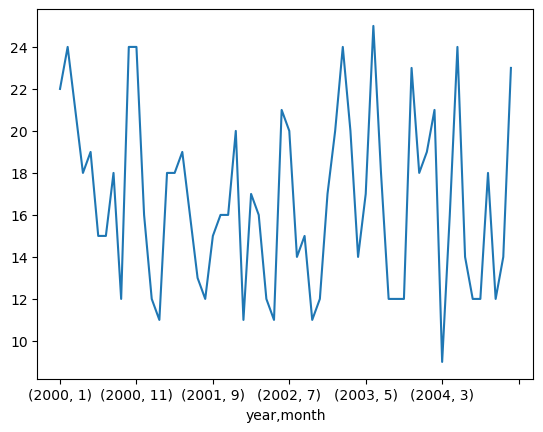

,name,type,n_calls,duration (msec)
0,to_datetime,kernel,3,6.575376
1,datetime_extract,kernel,3,2.438418
2,to_pandas.frame.metadata,kernel,1,1.455861
3,groupby_select_agg,kernel,1,0.957895
4,from_pandas.frame.metadata,kernel,1,0.292644
5,setitem,kernel,3,0.011522
6,getattr:plot,fallback,1,0.008294


In [6]:
%%fireducks.profile
demo_cse(s, is_eager_mode = True)

### 2. Dead Code Elimination

In [7]:
df1 = pd.DataFrame({"a": [1, 2, 3, 4], "b": [10, 11, 12, 13]})
df1

,a,b
0,1,10
1,2,11
2,3,12
3,4,13


In [8]:
df2 = pd.DataFrame({"a": [4, 1, 3], "c": [0, 1, 0], "d": [40, 10, 30]})
df2

,a,c,d
0,4,0,40
1,1,1,10
2,3,0,30


In [9]:
def demo_dce(df1, df2, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)
    
    merged_df = df1.merge(df2, on="a")
    sorted_df = merged_df.sort_values(by="a")
    #print(sorted_df)
    return merged_df.groupby("c")["d"].sum()

In [10]:
%%fireducks.profile
demo_dce(df1, df2, is_eager_mode = False)

c
0    70
1    10
Name: d, dtype: int64

,name,type,n_calls,duration (msec)
0,join,kernel,1,0.808730
1,to_pandas.frame.metadata,kernel,1,0.482110
2,groupby_select_agg,kernel,1,0.211675
3,Series.__repr__,fallback,1,0.192398
4,getattr:__repr__,fallback,1,0.007053
5,get_shape,kernel,1,0.000633


In [11]:
%%fireducks.profile
demo_dce(df1, df2, is_eager_mode = True)

c
0    70
1    10
Name: d, dtype: int64

,name,type,n_calls,duration (msec)
0,to_pandas.frame.metadata,kernel,1,1.591044
1,sort_values,kernel,1,1.273294
2,join,kernel,1,0.780758
3,Series.__repr__,fallback,1,0.179658
4,groupby_select_agg,kernel,1,0.149500
5,getattr:__repr__,fallback,1,0.004209
6,get_shape,kernel,1,0.000955


### 3. IO optimization

In [12]:
!wget -q https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet

In [13]:
def io_opt(is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)

    (
        pd.read_parquet("nyc_parking_violations_2022.parquet")
          .groupby("Vehicle Body Type")
          .agg(Count=("Summons Number", "count"))
          .sort_values(by="Count", ascending=False)
          .head(10)
          .plot(kind="bar")
    )

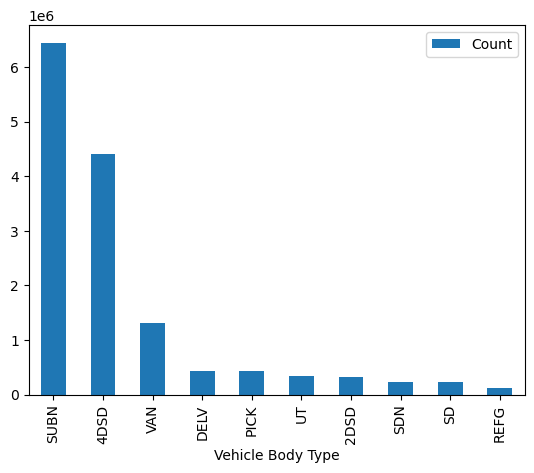

,name,type,n_calls,duration (msec)
0,read_parquet_with_metadata,kernel,1,317.417437
1,groupby_agg,kernel,1,33.684920
2,read_parquet_metadata,kernel,1,2.564383
3,sort_values,kernel,1,2.340698
4,to_pandas.frame.metadata,kernel,1,1.611257
5,getattr:plot,fallback,1,0.033412
6,slice,kernel,1,0.006278


In [14]:
%%fireducks.profile
io_opt(is_eager_mode = False)

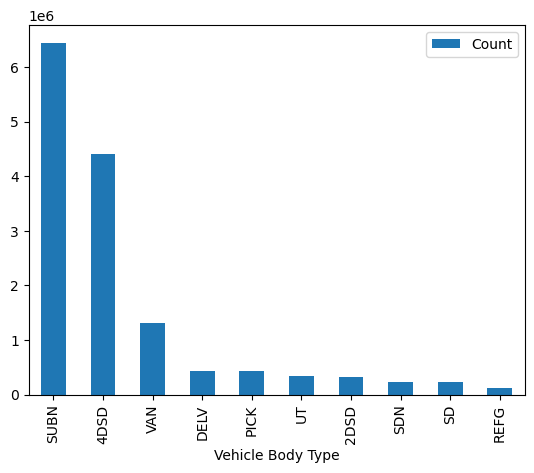

,name,type,n_calls,duration (msec)
0,read_parquet_with_metadata,kernel,1,1023.544810
1,groupby_agg,kernel,1,23.918245
2,read_parquet_metadata,kernel,1,2.045080
3,sort_values,kernel,1,1.861060
4,to_pandas.frame.metadata,kernel,1,1.738935
5,getattr:plot,fallback,1,0.035867
6,project,kernel,1,0.019753
7,slice,kernel,1,0.006755


In [15]:
%%fireducks.profile
io_opt(is_eager_mode = True)

### 4. Pushdown Projection

In [16]:
def generate_random_data(size):
    df = pd.DataFrame()
    df["A"] = np.random.choice(range(2000, 2010), size)
    for e in list("BCDEFGHIJKLMNOP"):
        df[e] = np.random.randn(size)
    return df

df = generate_random_data(10 ** 6)
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,2000,-0.617454,-0.562832,-0.071890,-0.076381,1.036705,0.689008,-0.715542,-0.689565,0.445745,0.036811,-1.027679,-0.168286,-0.505177,-1.292144,2.132774
1,2008,0.434558,0.857157,-1.369875,1.084111,0.297264,-0.236340,0.434167,-0.884024,-1.094095,0.538670,-0.220728,-1.501495,-0.327020,-0.070286,2.077076
2,2008,0.547083,-0.138239,-1.545669,0.061963,-1.537438,0.607111,0.898821,-1.866849,-0.069662,0.826040,1.025855,-0.893849,-1.143479,-0.112905,-0.275134
3,2008,-2.414939,1.446801,-0.094985,-0.056333,0.935500,-0.714562,2.013608,-0.131569,0.104997,1.179687,0.520535,0.261919,1.459865,1.012517,-0.192850
4,2001,-0.657255,0.381989,-1.844908,-1.407310,-0.014367,-1.672954,2.144249,0.708632,1.538692,0.852598,0.849463,-0.233870,-0.250426,-0.724886,-1.163106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2002,-2.076801,0.064667,-0.062633,1.276086,0.482027,-0.011199,0.348538,0.770074,2.991313,-1.978432,1.478588,-0.289546,0.963815,-1.214592,0.194360
999996,2005,0.575461,1.091272,1.928245,-1.160208,-0.419591,-0.062224,-0.154884,-0.331669,-0.537980,-1.674689,1.161966,-1.326228,0.274732,2.506850,-1.280451
999997,2007,-0.818619,1.176599,0.055466,1.718962,-0.666285,-3.010177,0.732047,0.458817,-0.341602,-1.127253,-0.189591,2.947977,2.268578,1.220717,1.087486
999998,2003,-1.093647,1.207023,-0.013913,0.892379,-1.068677,-0.836011,-0.196246,0.675581,0.373967,0.438104,-0.036027,0.169150,1.206493,-0.387732,-0.196827


In [17]:
def demo_pushdown_projection(df, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)
    
    res = df.groupby("A").sum()[["B", "C"]]
    print(res)

In [18]:
%%fireducks.profile
demo_pushdown_projection(df, is_eager_mode = False)

               B           C
A                           
2000  511.650886  161.926478
2001   26.887897  334.847947
2002  239.620418 -149.284129
2003  -26.383754  194.796791
2004  -81.182124 -126.473815
2005 -191.198510   75.264983
2006  176.457787  206.049365
2007 -132.033684 -124.138445
2008 -304.276128  276.005587
2009 -374.070234   86.897178


,name,type,n_calls,duration (msec)
0,DataFrame.__repr__,fallback,1,4.017287
1,groupby_agg,kernel,1,3.990249
2,to_pandas.frame.metadata,kernel,1,1.120824
3,project,kernel,2,0.017707
4,getattr:__repr__,fallback,1,0.007347
5,get_shape,kernel,1,0.001204


In [19]:
%%fireducks.profile
demo_pushdown_projection(df, is_eager_mode = True)

               B           C
A                           
2000  511.650886  161.926478
2001   26.887897  334.847947
2002  239.620418 -149.284129
2003  -26.383754  194.796791
2004  -81.182124 -126.473815
2005 -191.198510   75.264983
2006  176.457787  206.049365
2007 -132.033684 -124.138445
2008 -304.276128  276.005587
2009 -374.070234   86.897178


,name,type,n_calls,duration (msec)
0,groupby_agg,kernel,1,12.572085
1,DataFrame.__repr__,fallback,1,1.383711
2,to_pandas.frame.metadata,kernel,1,1.059785
3,project,kernel,1,0.008417
4,getattr:__repr__,fallback,1,0.003904
5,get_shape,kernel,1,0.001019


### 5. Predicate Pushdown

In [20]:
def demo_predicate_pushdown(df, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)
    
    res = df.sort_values(by="B").pipe(lambda df: df[(df["A"] > 2005) & (df["A"] < 2008)])
    print(res)

In [21]:
%%fireducks.profile
demo_predicate_pushdown(df, is_eager_mode = False)

           A         B         C         D         E         F         G  \
62391   2006 -4.463811  0.754143  0.153300 -0.172386 -1.748587  0.458146   
88881   2006 -4.258228 -0.692465 -1.321203 -0.073527 -1.811370  0.485723   
1366    2006 -4.220996 -0.010050  0.229037  0.503181  0.149457  0.048880   
226132  2006 -4.204926  0.065830  0.357137 -1.039008 -0.308514  0.149627   
306274  2006 -4.055949  0.680599  1.594621  1.729208 -2.114044 -0.130459   
...      ...       ...       ...       ...       ...       ...       ...   
249508  2007  4.038316 -0.098603  0.764420 -2.600522  0.647314  0.501543   
32729   2007  4.086244  0.150720  1.768089  0.974454  0.664310  1.679453   
405189  2007  4.119838  0.141369 -1.058238  1.079068  1.245891 -1.375537   
563425  2006  4.225250 -0.080203  0.633712  0.136609 -1.441177  0.135714   
53599   2007  4.456451 -1.152054 -0.013207  1.358354 -0.668268 -1.163778   

               H         I         J         K         L         M         N  \
62391  

,name,type,n_calls,duration (msec)
0,sort_values,kernel,1,26.850117
1,filter,kernel,1,5.132750
2,DataFrame.__repr__,fallback,1,4.332570
3,to_pandas.frame.metadata,kernel,1,0.857381
4,lt.vector.scalar,kernel,1,0.514031
5,gt.vector.scalar,kernel,1,0.386572
6,and.vector.vector,kernel,1,0.366837
7,slice,kernel,2,0.041909
8,get_shape,kernel,2,0.032773
9,concat,kernel,1,0.024365


In [22]:
%%fireducks.profile
demo_predicate_pushdown(df, is_eager_mode = True)

           A         B         C         D         E         F         G  \
62391   2006 -4.463811  0.754143  0.153300 -0.172386 -1.748587  0.458146   
88881   2006 -4.258228 -0.692465 -1.321203 -0.073527 -1.811370  0.485723   
1366    2006 -4.220996 -0.010050  0.229037  0.503181  0.149457  0.048880   
226132  2006 -4.204926  0.065830  0.357137 -1.039008 -0.308514  0.149627   
306274  2006 -4.055949  0.680599  1.594621  1.729208 -2.114044 -0.130459   
...      ...       ...       ...       ...       ...       ...       ...   
249508  2007  4.038316 -0.098603  0.764420 -2.600522  0.647314  0.501543   
32729   2007  4.086244  0.150720  1.768089  0.974454  0.664310  1.679453   
405189  2007  4.119838  0.141369 -1.058238  1.079068  1.245891 -1.375537   
563425  2006  4.225250 -0.080203  0.633712  0.136609 -1.441177  0.135714   
53599   2007  4.456451 -1.152054 -0.013207  1.358354 -0.668268 -1.163778   

               H         I         J         K         L         M         N  \
62391  

,name,type,n_calls,duration (msec)
0,sort_values,kernel,1,58.073371
1,DataFrame.__repr__,fallback,1,5.641574
2,filter,kernel,1,5.069929
3,to_pandas.frame.metadata,kernel,1,1.400174
4,gt.vector.scalar,kernel,1,0.554111
5,lt.vector.scalar,kernel,1,0.538122
6,and.vector.vector,kernel,1,0.410222
7,slice,kernel,2,0.123218
8,concat,kernel,1,0.034459
9,project,kernel,2,0.014204
